## **Import Dataset**

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T150806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0384286882e57ed5979a453d3b36e2d5ac7c5683c21364a514272ce697b7a7430176301d285f6982230aa12ded3cf24f63136365e5939a1b4cf6a627f90b21b558772ac2b852ceeda8c9115147d5d45101662dbded2dc256b64c8607b23b8a2e138946585e223ab27c2e6ced66542d64b390b7a29fb5f28667574314b9b5d6a1e728981f43b957023ed099b2adfc9609101a051eb013f254b576ffd5c986f20ab81845f69f45dcde2f9c5e05f1e3fc15e3aed90b0112a274ad37e14053eb8e6d8635f649c8362c1478bc8b587d074f6474c488f679d16695f5ed6a20ddea00f6dc13ab4b1746b75013f78e36b46727d42ca74c2ba6b6d35bd214cd27c5751ebb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


## Load the dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
train = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
test = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')



Training data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(3000000, 3)
Testing data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(650000, 3)


## Check Columns

In [ ]:
print("Training data set")
print(train.columns)
print(train.shape)

print("Testing data set")
print(test.columns)
print(test.shape)

## Train the Data

In [9]:
train_sample = train.sample(n=70000, random_state=42)
test_sample = test.sample(n=15000, random_state=42)

In [10]:
texts = train_sample['review_text'].astype(str).values
labels = train_sample['class_index'].values


In [11]:
# Tokenization
max_length = 200  # Max length for each review
vocab_size = 10000  # Vocabulary size (can tune this)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post') #padding

## Conversion

In [12]:
# Convert sentiment classes to numerical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert to categorical (one-hot encoding)
categorical_labels = to_categorical(encoded_labels, num_classes=5)

In [13]:
# Step 5: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, categorical_labels, test_size=0.2, random_state=42)

In [14]:
# Step 7: Prepare Testing Data
# Preprocess the separate test dataset
test_texts = test_sample['review_text'].astype(str).values  # Text reviews from test set
test_labels = test_sample['class_index'].values  # Sentiment classes from test set

# Tokenize and pad the test texts
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')



In [15]:
# Convert sentiment classes to numerical labels for test data
test_encoded_labels = label_encoder.transform(test_labels)  # Use transform instead of fit_transform
test_categorical_labels = to_categorical(test_encoded_labels, num_classes=5)


In [18]:
from tensorflow.keras.layers import SimpleRNN

# Build the Simple RNN Model
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))

# Simple RNN Layer
model.add(SimpleRNN(64, activation='relu', return_sequences=False))  # Set return_sequences=False for the last RNN layer

# Dense Layer
model.add(Dense(10, activation='relu'))

# Output Layer with Softmax for multi-class classification (5 classes)
model.add(Dense(5, activation='softmax'))

# Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
 # Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the Model
test_loss, test_acc = model.evaluate(test_padded_sequences, test_categorical_labels)
print(f'Test Accuracy: {test_acc}')


Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 74s 81ms/step - accuracy: 0.1995 - loss: 1.6488 - val_accuracy: 0.1958 - val_loss: 1.6097
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 79s 78ms/step - accuracy: 0.1990 - loss: 1.6095 - val_accuracy: 0.1959 - val_loss: 1.6096
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.2017 - loss: 1.6094 - val_accuracy: 0.2039 - val_loss: 1.6094
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - accuracy: 0.1992 - loss: 1.6094 - val_accuracy: 0.1959 - val_loss: 1.6097
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.2061 - loss: 1.6093 - val_accuracy: 0.1984 - val_loss: 1.6095
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.2022 - loss: 1.6094 - val_accuracy: 0.2039 - val_loss: 1.6096
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 83s 79ms/step - accuracy: 0.2018 - loss: 1.6094 - val_accuracy: 0.1984 - val_loss: 1.6097
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 69s 79ms/step - accuracy: 0.2006 - loss: 1.6093 - 

In [23]:
import matplotlib.pyplot as plt  # Make sure to import matplotlib

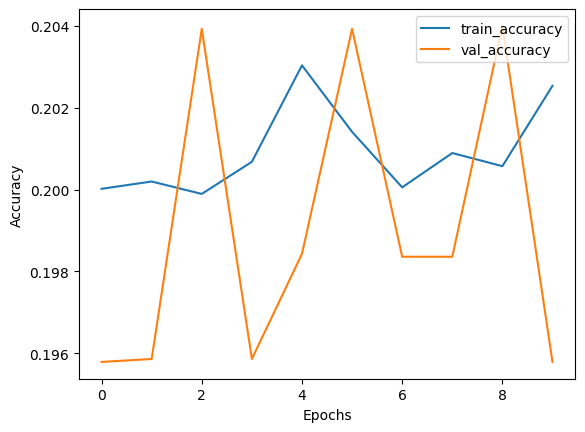

In [24]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

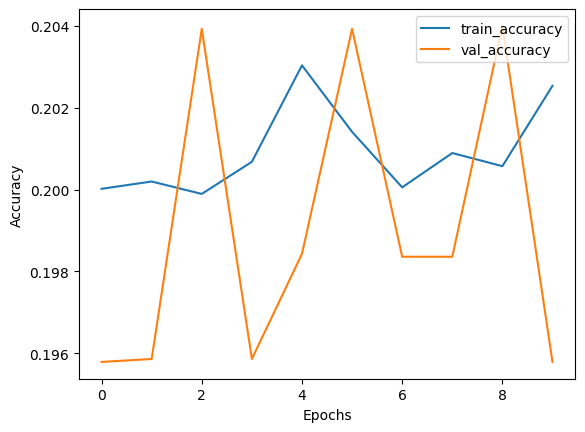

In [25]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()